## Introduction

This notebook makes the matter power spectrum figure from [Chabanier et al. (2019)](link-not-live-yet) and [Planck 2018: I (2018)](https://arxiv.org/abs/1807.06205). 

You can chose "Run All" and the very last cell of the notebook creates the plot (the notebook will take about ~10min to run through the first time, the majority of time spent on a very-high-accuracy call to CAMB). 

*Note:* the differents sections make use of some of the same variables names (e.g. `k` and `z`), so if you go back to re-evaluate something in a section, make sure to re-evaluate the entire section from the beginning to reset these variables.

This notebook is written in [Julia](https://julialang.org/). It also calls a number of Python functions, and performs plotting via matplotlib. 

## Intitialization

In [1]:
using Base.Iterators: take, repeated
import Base: getindex

using DelimitedFiles
using FITSIO
using Interpolations
using LinearAlgebra
using Optim
using PyCall
using PyPlot
using SpecialFunctions
using Statistics

camb = pyimport("camb")
trapz(x,f,axis=0) = pyimport("scipy.integrate").trapz(f,x,axis=axis);

## Fiducial model

These values can be changed, then the whole notebook can be rerun to produce the final plot assuming a different ficudical model:

In [2]:
τ   = 0.0543
Aₛ  = exp(3.0448)*1e-10
nₛ  = 0.96605
H₀  = 67.32
h   = H₀/100
ωb  = 0.022383
ωc  = 0.12011
Σmν = 0.06

kₚ  = 0.05
T₀  = 2.7255

Ωm = (ωc+ωb+Σmν/94)/h^2
ΩΛ = 1 - Ωm;

## CMB and matter transfer functions

Here we call CAMB to compute the CMB and matter transfer functions. Note we're computing them at every $\ell$ and at somewhat higher accuracy than normal, so this step may take a few minutes. 

In [3]:
z = z_CMB = collect(range(0,3.5,length=150));

In [4]:
p = camb.set_params(
    As=Aₛ, ns=nₛ, H0=H₀, ombh2=ωb, omch2=ωc, tau=τ, mnu=Σmν, 
    pivot_scalar=kₚ, AccuracyBoost=2, lSampleBoost=50, TCMB=T₀, redshifts=z, k_eta_fac=10, lmax=2600
)
r = camb.get_results(p)
t = r.get_cmb_transfer_data()
mt = r.get_matter_transfer_data();

In [5]:
ℓ = ℓ_CMB = 1:2508
toCℓ = @. 1/(ℓ*(ℓ+1)/(2π))

CℓTT = @. 1e12 * T₀^2 * r.get_unlensed_scalar_cls(2508)[2:end,1] * toCℓ
CℓEE = @. 1e12 * T₀^2 * r.get_unlensed_scalar_cls(2508)[2:end,2] * toCℓ
CℓTE = @. 1e12 * T₀^2 * r.get_unlensed_scalar_cls(2508)[2:end,4] * toCℓ
Cℓϕϕ = @.      1/(2π) * r.get_lens_potential_cls(2508)[2:end,1]  * toCℓ^2;

Next, take the output from CAMB and put it in our matrix `Wkℓ` $\equiv W_\ell(k)$ defined such that

$$
C_\ell = \int d\ln k \;W_\ell(k) P_*(k)
$$

where $P_*(k)$ is the primordial power spectrum. 

In [6]:
k = k_CMB = t.q
dlnk = diff(log.(k))
dlnk = [dlnk[1]; dlnk]

WkℓTT = @. 4*pi*1e12*T₀^2 * t.delta_p_l_k[1,:,:]^2
WkℓTT = [0; WkℓTT][ℓ,:]

WkℓEE = @. 4*pi*1e12*T₀^2 * t.delta_p_l_k[2,:,:]^2
WkℓEE = [0; WkℓEE][ℓ,:] .* (ℓ.*(ℓ.+1)).^2

WkℓTE = @. 4*pi*1e12*T₀^2 * t.delta_p_l_k[1,:,:] .* t.delta_p_l_k[2,:,:]
WkℓTE = [0; WkℓTE][ℓ,:] .* (ℓ.*(ℓ.+1))

Wkℓϕϕ = @. 4*pi * t.delta_p_l_k[3,:,:]^2
Wkℓϕϕ = [0; Wkℓϕϕ][ℓ,:];

We can check this is right by doing the sum over $P_*(k)$ ourselves to verify we get the CMB spectrum back:

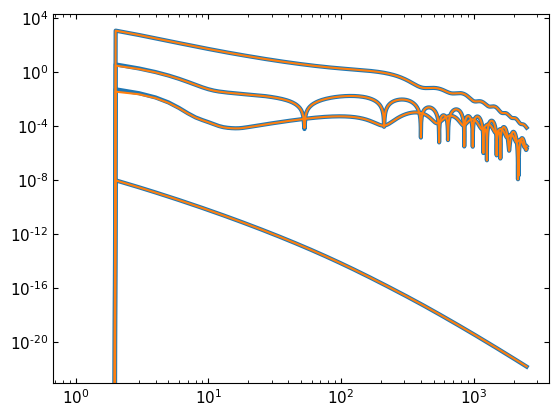

In [7]:
loglog(ℓ,      WkℓTT * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
loglog(ℓ,      WkℓEE * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
loglog(ℓ, abs.(WkℓTE * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk)), lw=3, c="C0")
loglog(ℓ,      Wkℓϕϕ * (Aₛ*(k/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")


loglog(ℓ,      CℓTT,  c="C1")
loglog(ℓ,      CℓEE,  c="C1")
loglog(ℓ, abs.(CℓTE), c="C1")
loglog(ℓ,      Cℓϕϕ,  c="C1");

Similarly, compute the matter transfer functions, such that 
$$P(k) = T(k)^2 P_*(k)$$

In [8]:
Pdat   = camb.get_matter_power_interpolator(p, nonlinear=false, hubble_units=false, k_hunit=false, kmax=15, zmax=3.5, extrap_kmax=500)
PNLdat = camb.get_matter_power_interpolator(p, nonlinear=true,  hubble_units=false, k_hunit=false, kmax=15, zmax=3.5, extrap_kmax=500);

In [9]:
Pkz(k,z) = Pdat.P(z,k)
PNLkz(k,z) = PNLdat.P(z,k)
Tkz²(k,z) = Pkz(k,z) ./ (Aₛ*(k/kₚ).^(nₛ-1))

getindex(::typeof(Pkz), idx...) = Pkz(idx...)
getindex(::typeof(PNLkz), idx...) = PNLkz(idx...)
getindex(::typeof(Tkz²), idx...) = Tkz²(idx...);

and recompute the matter spectrum by hand to check everything is right:

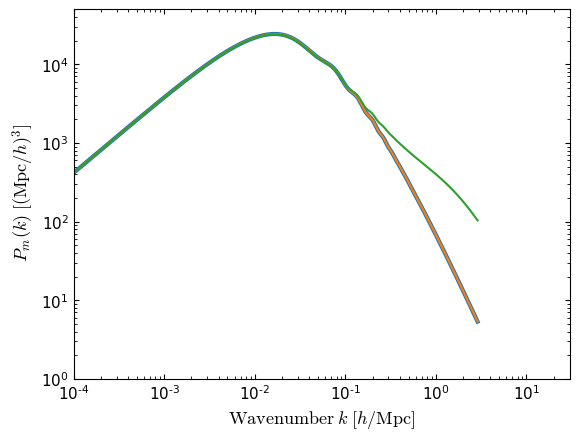

In [10]:
loglog(k/h, h^3 *  Tkz²[k,0] .* (Aₛ*(k/kₚ).^(nₛ-1)),lw=3)
loglog(k/h, h^3 *   Pkz[k,0]);
loglog(k/h, h^3 * PNLkz[k,0]);

xlim(1e-4,30)
ylim(1,5e4)
ylabel(raw"$\; P_m(k) \; [({\rm Mpc}/h)^3]$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");

## Planck

In [11]:
ℓ = ℓ_CMB;
k = k_CMB;

### Low-ℓ

In [12]:
toDℓ = @. (2:29)*((2:29)+1)/(2π)
(d_low_TT, σ_low_TT) = (readdlm("dat/cls_commander_2018_rc_TT.dat", comments=true)[1:28,i] ./ toDℓ for i=4:5);

### High-ℓ

In [13]:
# the binning specification
blmin, blmax = (round.(Int,readdlm("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/bl$m.dat")) for m=["min","max"])
bweight = readdlm("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/bweight.dat");
B_high = hcat([(r=zeros(2508); r[(30+lmin):(30+lmax)]=bweight[(1+lmin):(1+lmax)]; r) for (lmin,lmax) in take(zip(blmin,blmax),214)]...);

# the covariance
Σ_high = (open("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v22.dat") do f
    read(f,Int32) #fortran header
    s = read!(f,Matrix{Float64}(undef, 613, 613))
    (s+s') - Diagonal(diag(s))
end);
Σ_high_TT = Σ_high[1:214,1:214]
Σ_high_TE = Σ_high[216:414,216:414]
Σ_high_EE = Σ_high[415:end,415:end]

# the data
d_high_TT = readdlm("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[1:214,2]
d_high_TE = readdlm("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[216:414,2]
d_high_EE = readdlm("dat/plik_lite_v22_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v22.dat")[415:end,2];

In [14]:
# for TT, combine low and high-L into a single vector
n_low, n_high = length(d_low_TT), length(d_high_TT)
d_planck_TT = [d_low_TT; d_high_TT]
Σ_planck_TT = [Diagonal(σ_low_TT.^2) zeros(n_low,n_high); zeros(n_high,n_low) Σ_high_TT]
B_planck_TT = [[zeros(1,28); I; zeros(2507-28, 28)] B_high]

nbinsTT = size(B_planck_TT,2);
nbinsEE = size(B_high,2);

Plot data up with theory curve to sanity check we've loaded everything right:

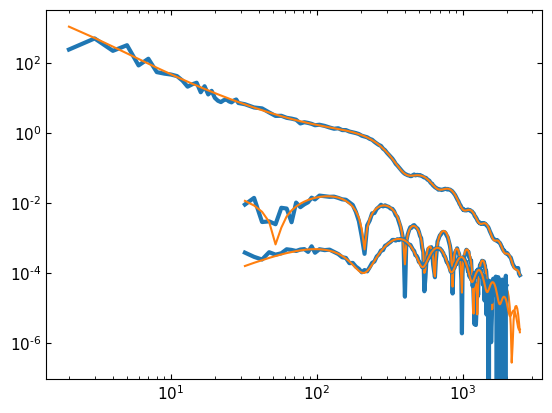

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7820bc3518>

In [15]:
loglog((B_planck_TT'*ℓ), d_planck_TT, C="C0", lw=3)
plot(B_planck_TT'*ℓ, B_planck_TT'*CℓTT,c="C1")

loglog((B_high'*ℓ)[1:199], abs.(d_high_TE), c="C0", lw=3)
plot(B_high'*ℓ, B_high'*abs.(CℓTE),c="C1")

loglog((B_high'*ℓ)[1:199], d_high_EE, c="C0", lw=3)
plot(B_high'*ℓ, B_high'*CℓEE,c="C1")

### Lensing

In [16]:
d = readdlm("dat/planck_lensing_2018/smicadx12_Dec5_ftl_mv2_ndclpp_p_teb_agr2_bandpowers.dat", comments=true)
d_ϕϕ = d[:,5]
Σ_ϕϕ = Diagonal(d[:,6].^2)
blmin,blmax = Int.(d[:,2]), Int.(d[:,3])
B_ϕϕ = hcat([(r=zeros(2508); r[lmin:lmax].=1/(lmax-lmin+1); r) for (lmin,lmax) in zip(blmin,blmax)]...);

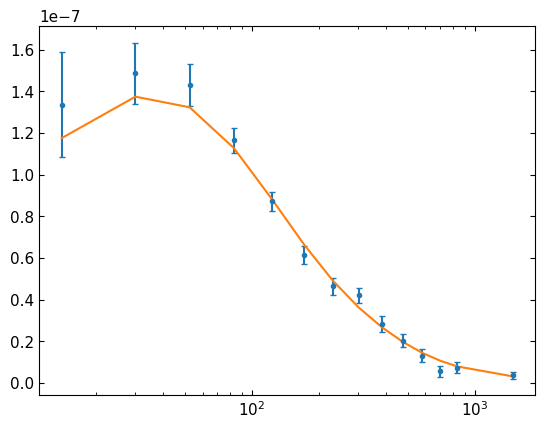

In [17]:
errorbar((blmin+blmax)/2, d_ϕϕ, sqrt.(diag(Σ_ϕϕ)),marker=".",ls="")
semilogx((blmin+blmax)/2, B_ϕϕ' * (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)));

### Functions for plotting Planck data

In [18]:
# gets 20/50/80% quantiles of a probability distribution P(x) * dx, 
function get_quantiles(x, Px, dx)
    cs = cumsum(abs.(Px) .* dx)
    cs /= cs[end]
    inz = @. (cs>0) & (cs<1)
    itp = interpolate((cs[inz],),x[inz],Gridded(Linear()))
    itp[[0.2,0.5,0.8]]
end

get_quantiles (generic function with 1 method)

In [19]:
function get_plot_data(d, Σ, B, Cℓ, Wkℓ, k, ℓ, nrebin, tg_style=false)
    
    # rebin the data
    lmins = cumsum([1; nrebin])[1:end-1]
    lims = zip(lmins, @. lmins+nrebin-1)
    nbins = size(B,2)
    B2 = hcat([(r=zeros(nbins); r[l1:l2].=1; normalize!(r,1)) for (l1,l2)=lims]...);
    nbins2 = size(B2,2)
    
    # compute 
    if tg_style
        Wki = B2'*B'*Wkℓ
    else
        Wki = B2'*B'*Wkℓ ./ Tkz²[k,0]'
    end
    Pi = Wki ./ sum(Wki .* dlnk', dims=2)
    ℓkmap = hcat(get_quantiles.((k,),[Pi[i,:] for i=1:nbins2],(dlnk,))...)'
    
    σCℓ_over_Cℓ = sqrt.(diag(B2'*Σ*B2)) ./ (B2'*d)
    f = (B2' * d) ./ (B2' * B' * Cℓ)
    
    σCℓ_over_Cℓ, ℓkmap, f, Pi, B2'*B'*ℓ
    
end
    
function make_plot(σCℓ_over_Cℓ, ℓkmap, f, args...; residual=false, kpow=0, kwargs...)
    
    # make plot
    m = h^3 * Pkz[ℓkmap[:,2],0] .* ℓkmap[:,2].^kpow
    errorbar(
        ℓkmap[:,2]/h,
        residual ? m.*(f.-1) : m.*f;
        yerr = m .* σCℓ_over_Cℓ,
        xerr = abs.(ℓkmap[:,[1,3]].-ℓkmap[:,2])'/h,
        ebar_kwargs...,
        kwargs...
    )
    
end

make_plot (generic function with 1 method)

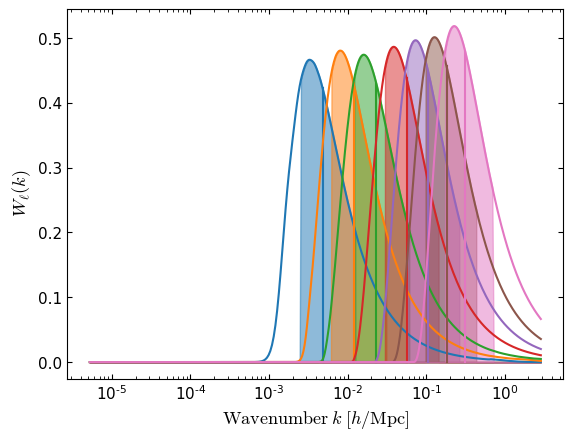

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{ExpandedIndexTypes, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = get_quantiles(::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}) at In[18]:7
└ @ Main ./In[18]:7


In [20]:
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, [[1, 3, 15, 15]; fill(5,2); fill(10,5); fill(20,7)])
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, [fill(5,2); fill(10,5); fill(20,6); 19])
# _,ℓkmap,_,Pi,ℓbin = get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, k, [fill(5,2); fill(10,5); fill(20,6); 19])
_,ℓkmap,_,Pi,ℓbin = get_plot_data(d_ϕϕ,   Σ_ϕϕ,   B_ϕϕ, Cℓϕϕ, Wkℓϕϕ, k, ℓ, [1,1,2,2,2,3,3], false)


for i = 1:1:size(ℓkmap,1)
    T = Pi[i,:]
    l, = semilogx(k/h, T)
    low,mid,high = get_quantiles(k, T, [0; diff(log.(k))])
    fill_between(k/h, 0T, T.*ifelse.(low.<k.<high,1,0), color=l.get_color(), alpha=0.5)
    imid = findmin(@. (k-mid)^2)[2]
    plot(fill(k[imid]/h,2),[0,T[imid]], color=l.get_color())

end
ylabel(raw"$\; W_{\ell}(k) $")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");

## Reid et al. 2010 $P_{halo}(k)$

Here we call the modified version of CAMB to compute the halo matter power spectrum (instead of the linear matter power spectrum), using the fiducial cosmological parameters specified above:

In [21]:
camb09 = pyimport("camb4py").load("../src/camb-feb09/camb",defaults="dat/lrgdr7like/CAMBfeb09patch/params.ini")
Pk_halo = camb09(;Dict(Symbol(k)=>v for (k,v) in Dict(
    "re_optical_depth" => τ,
    "scalar_amp(1)" => Aₛ,
    "scalar_spectral_index(1)" => nₛ,
    "hubble" => H₀,
    "ombh2" => ωb,
    "omch2" => ωc,
    "pivot_scalar" => kₚ,
    "temp_cmb" => T₀
))...)["transfer_matterpower"][2:end,1:2]
Pk_halo = LinearInterpolation(Pk_halo[:,1],Pk_halo[:,2]);

Now we load Reid et al. 2010 data:

In [22]:
(k_reid,d_reid_Pk) = eachcol(readdlm("dat/lrgdr7like/data/lrgdr7_ccmeasurements.txt",comments=true)[:,[1,4]])
Σ_reid_Pk = inv(readdlm("dat/lrgdr7like/data/lrgdr7_invcov.txt",comments=true))
σ_reid_Pk = sqrt.(diag(Σ_reid_Pk));

Finally, we compute the best fit bias parameters:

In [23]:
Fnuis(k,b₀=1,a₁=0.172,a₂=-0.198) = (kₛ=0.2/h; b₀^2*(1+a₁*(k/kₛ)+a₂*(k/kₛ)^2))
lnL(x) = (Δ = Pk_halo(k_reid) .* Fnuis.(k_reid,x...) - d_reid_Pk; Δ'*(Σ_reid_Pk\Δ))
x_nuis_reid = optimize(lnL,Float64[1,0,0]).minimizer

3-element Array{Float64,1}:
  1.2484744246536563 
  0.5427752758749185 
 -0.33925665638689645

## Lyman-alpha forest

In [24]:
k_lyaf, Pk_lyaf, σ_lyaf_Pk = eachcol(readdlm("dat/lya/DR14_pm3d_19kbins.txt"));

## DES

The DES calculation assumes the following relation:

$$
\begin{align}
\xi_\pm^{ij}(\theta) = \frac{1}{2\pi} \int d\ln k\; \underbrace{\left[ \int_0^{\chi^H} d\chi \; \ell(\ell+1/2) J_{0/4}(\theta\ell)  \frac{q^i(\chi)q^j(\chi)}{\chi^2} \frac{P(k,\chi)}{P(k,0)} \right]}_{ T_{\xi P}(\theta,k)} P(k,0)
\end{align}
$$

where
$$
\begin{align}
k = \frac{\ell+1/2}{\chi}
\end{align}
$$

and the quantity in brackets $T_{\xi P}(\theta,k)$ are the transfer functions which we compute in this section which give us the $k$-direction error bars.

Load source counts:

In [25]:
nz_source_dat = readdlm("dat/des/DES_1YR_final_nz_source.dat", comments=true)
zmid = nz_source_dat[:,2]
nz_source = [LinearInterpolation(zmid,nz_source_dat[:,i],extrapolation_bc=0) for i=4:7];

Load $\theta$-bins:

In [26]:
θ_DES_arcmin = readdlm("dat/des/DES_1YR_final_theta_bins.dat", comments=true)[:]
θ_DES = deg2rad.(θ_DES_arcmin/60)[:];

Load best-fit nuisance parameters:

In [27]:
des_fit = Dict(k=>v for (v,k) in eachrow(readdlm("dat/des/base_DES_DESpriors.minimum", comments=true)[1:end-2,2:3]));
wl_photoz_errors             = [des_fit["DES_DzS$i"] for i=1:4]
lens_photoz_errors           = [des_fit["DES_DzL$i"] for i=1:5]
bin_bias                     = [des_fit["DES_b$i"] for i=1:5]
shear_calibration_parameters = [des_fit["DES_m$i"] for i=1:4]
intrinsic_alignment_A        = des_fit["DES_AIA"]
intrinsic_alignment_alpha    = des_fit["DES_alphaIA"]
intrinsic_alignment_z0       = 0.62;
shear_calibration = @. (1+shear_calibration_parameters)*(1+shear_calibration_parameters)';

Calculate theory spectra:

In [28]:
z = z_DES = 10 .^ range(-4, log10(3.5), length=600)
k = k_DES = 10 .^ range(-3, 1, length=600);

In [29]:
c = 299792.458 #in km/s;

In [30]:
χ = r.comoving_radial_distance(z)
ℓ = @. k*χ'-1/2;
D_growth = @. sqrt(Tkz²[1,z] / Tkz²[1,1]);
Hz = r.h_of_z(z);

nχ = @. Hz * map($permutedims(nz_source), z - wl_photoz_errors')

Alignment_z = @. intrinsic_alignment_A * (((1 + z) / (1 + intrinsic_alignment_z0)) ^ intrinsic_alignment_alpha) * 0.0134 / D_growth;
w_align = @. Alignment_z * nχ / (χ * (1 + z) * (3/2) * (H₀/c)^2);

w = hcat([[trapz(χ[i:end], (@. nχ[:,j] * (1 - χ[i]/χ))[i:end]) for i=eachindex(χ)] for j=1:4]...);

q = @. (3/2) * Ωm * (H₀/c)^2 * χ * (1 + z) * (w - w_align);

`q` is the lensing efficiency function:

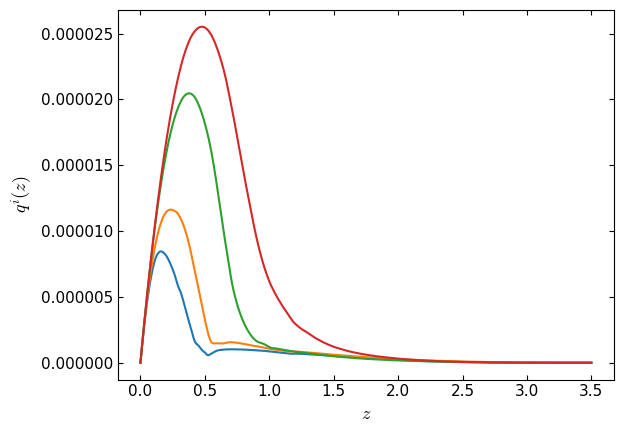

In [31]:
plot(z,q)
xlabel(raw"$z$")
ylabel(raw"$q^i(z)$");

The correlation functions:

In [32]:
ijs = [(i,j) for j=1:4, i=1:4 if i<=j];

In [33]:
Pκ = Dict((i,j) => (@. q[:,i]*q[:,j]/χ^2 * PNLkz[k,z]) for (i,j)=ijs)

@time (ξ₊_θ, ξ₋_θ) = (Dict((i,j) => [0.85/2π * trapz(log.(k), trapz(χ, (@. ℓ*(ℓ+1/2)*besselj(n,θ*ℓ) * Pκ[i,j]'), 1)) * shear_calibration[i,j] for θ=θ_DES] 
    for (i,j)=ijs) for n=(0,4));

 19.409942 seconds (1.93 M allocations: 1.171 GiB, 1.68% gc time)


Load DES data and covariance:

In [34]:
ξ₊_DES  = Dict((i,j)=>x for ((i,j),x) in zip(ijs,eachcol(reshape(readdlm("dat/des/DES_1YR_final_xip.dat", comments=true)[:,4],20,10))))
ξ₋_DES  = Dict((i,j)=>x for ((i,j),x) in zip(ijs,eachcol(reshape(readdlm("dat/des/DES_1YR_final_xim.dat", comments=true)[:,4],20,10))))
covξ₊_DES = readdlm("dat/des/DES_1YR_final_cov.dat")[1:200,1:200]
covξ₋_DES = readdlm("dat/des/DES_1YR_final_cov.dat")[201:400,201:400]
σξ₊_DES = Dict((i,j)=>x for ((i,j),x) in zip(ijs,eachcol(reshape(sqrt.(diag(readdlm("dat/des/DES_1YR_final_cov.dat", comments=true)))[1:200],20,10))));
σξ₋_DES = Dict((i,j)=>x for ((i,j),x) in zip(ijs,eachcol(reshape(sqrt.(diag(readdlm("dat/des/DES_1YR_final_cov.dat", comments=true)))[201:400],20,10))));
ξ₊cut_DES = Dict((i,j)=>[θmin,θmax] for (i,j,θmin,θmax) in eachrow(readdlm("dat/des/DES_1YR_final_selection.dat", comments=true)[1:10,2:end]));
ξ₋cut_DES = Dict((i,j)=>[θmin,θmax] for (i,j,θmin,θmax) in eachrow(readdlm("dat/des/DES_1YR_final_selection.dat", comments=true)[11:20,2:end]));

Plot data vs. theory for sanity check:

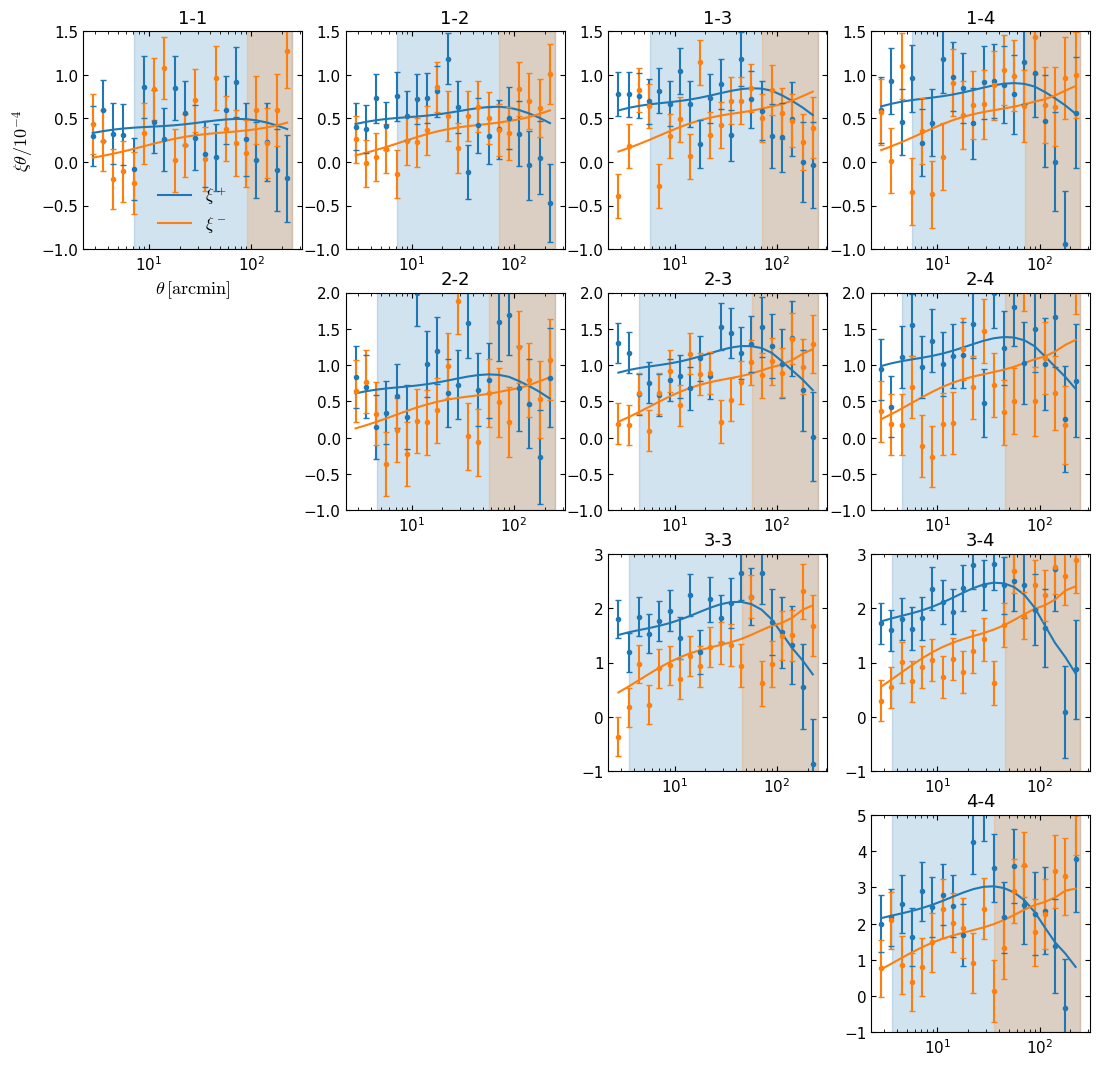

In [35]:
figure(figsize=(13,13))
for i=1:4, j=1:4
    if i<=j
        subplot(4,4,4*(i-1)+j)
        fac = 1e4 * θ_DES_arcmin
        
        semilogx(θ_DES_arcmin, fac .* ξ₊_θ[i,j], c="C0")
        semilogx(θ_DES_arcmin, fac .* ξ₋_θ[i,j], c="C1")
        
        errorbar(θ_DES_arcmin, fac .* ξ₊_DES[i,j], fac .* σξ₊_DES[i,j], marker=".", ls="", c="C0")
        errorbar(θ_DES_arcmin, fac .* ξ₋_DES[i,j], fac .* σξ₋_DES[i,j], marker=".", ls="", c="C1")
        
        title("$i-$j")
        if i==j==1
            legend([raw"$\xi^+$",raw"$\xi^-$"])
            xlabel(raw"$\theta\,[\rm arcmin]$")
            ylabel(raw"$\xi\theta/10^{-4}$")
        end
        ylim(-1,[1.5,2,3,5][i])
        
        let (ymin,ymax)=ylim(); 
            fill_between(ξ₊cut_DES[i,j], fill(ymin,2), fill(ymax,2), color="C0", alpha=0.2)
            fill_between(ξ₋cut_DES[i,j], fill(ymin,2), fill(ymax,2), color="C1", alpha=0.2)
        end
    end
end

Now compute the transfer function, $T_{\xi P}(\theta,k)$. Note, we use a trick from Section B of Tegmark & Zaldarriaga 2002 to account for the impact from nonlinearities on which $k$ scales a given measurement is sensitive to:

In [36]:
function fNL(x,n=nₛ)
    A = 0.482*(1+n/3)^-0.947
    B = 0.226*(1+n/3)^-1.778
    α = 3.310*(1+n/3)^-0.244
    β = 0.862*(1+n/3)^-0.287
    V = 11.55*(1+n/3)^-0.423
    g = 5/2*Ωm*(Ωm^(4/7)-ΩΛ+(1+Ωm/2)*(1+ΩΛ/70))^-1
    x * ((1+B*β*x+(A*x)^(α*β)) / (1+(((A*x)^α)*g^3/(V*sqrt(x))^β)))^(1/β)
end

fNL (generic function with 2 methods)

In [37]:
Δ²(k,z=0)   = @. 4π*k^3/(2π)^3*Pkz[k,z]
ΔNL²(k,z=0) = @. 4π*k^3/(2π)^3*PNLkz[k,z]

ΔNL² (generic function with 2 methods)

In [38]:
k′_of_k(k, z=0) = @. k * (1 + fNL($Δ²(k))/(1+z')^2)^(-1/3)
k_of_k′(k′,z=0) = hcat([LinearInterpolation(k′_of_k(k,z), k, extrapolation_bc=Line()).(k′) for z=z]...)

k_of_k′ (generic function with 2 methods)

In [39]:
k′ = 10 .^ range(-3,log10(100),length=600)
ℓ = max.(0, k_of_k′(k′,z).*χ' .- 1/2);
dlnk_dlnk′ = [ones(length(χ))'; diff(log.(k_of_k′(k′,z)),dims=1) ./ diff(log.(k′))];

In [40]:
Pκ = Dict((i,j) => (@. q[:,i]*q[:,j]/χ^2 * Pkz[k′,z] / Pkz[k′,0]') for (i,j)=ijs)

@time (Tξ₊P,Tξ₋P) = (Dict((i,j) => [trapz(χ, (@. dlnk_dlnk′*ℓ*(ℓ+1)*besselj(n,θ*ℓ) * Pκ[i,j]'), 1) for θ=θ_DES]
    for (i,j)=ijs) for n=(0,4));

 21.053727 seconds (1.39 M allocations: 1.141 GiB, 1.32% gc time)


Plot up some of the transfer functions:

In [41]:
killhighfreqnoise(x) = (i=findfirst(x.<0); x[(i==nothing ? end : i-10):end].=0; x[end-10:end].=0; x ./ sum(abs.(x)))

killhighfreqnoise (generic function with 1 method)

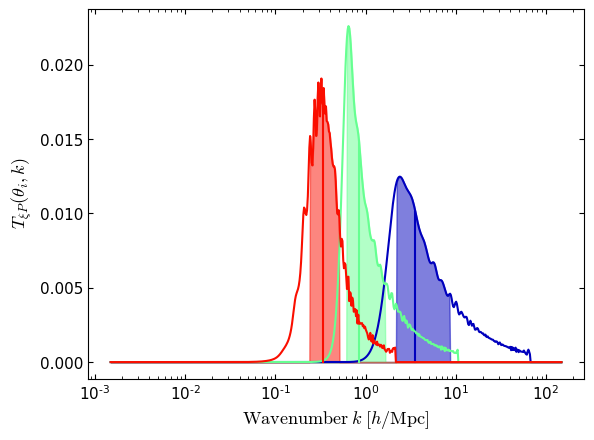

In [42]:
for i=1:1,j=1:1,θ=1:8:20
    T = killhighfreqnoise(Tξ₋P[i,j][θ])
    l, = semilogx(k′/h, T, c=get_cmap("jet",20)(θ))
    low,mid,high = get_quantiles(k′, T, [0; diff(log.(k′))])
    fill_between(k′/h, 0T, T.*ifelse.(low.<k′.<high,1,0), color=l.get_color(), alpha=0.5)
    imid = findmin(@. (k′-mid)^2)[2]
    plot(fill(k′[imid]/h,2),[0,T[imid]], color=l.get_color())
end

# ylim(0,0.03)
ylabel(raw"$\; T_{\xi P}(\theta_i,k)$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$");

Bin together different redshifts (one could chose different binning, this one seems to give 5 adequately spaced bins in the end):

In [43]:
B = hcat([vcat(repeated([zeros(4*i); ones(4); zeros(20-4*(i+1))],10)...) for i=0:4]...);

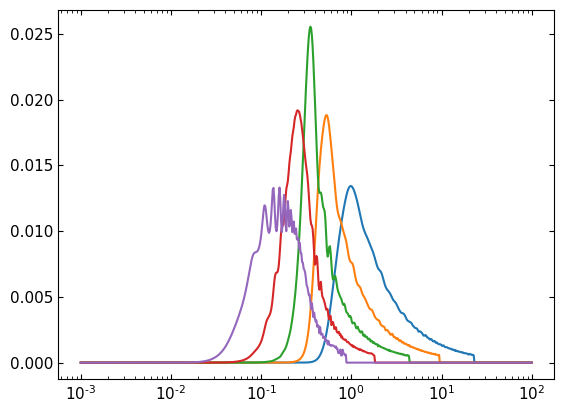

In [44]:
semilogx.((k′,), killhighfreqnoise.(B' * vcat((Tξ₋P[i,j] for (i,j)=ijs)...)));

In [45]:
ξb_theory = B' * vcat((ξ₋_θ[i,j] for (i,j) in ijs)...)
ξb_data = B' * vcat((ξ₋_DES[i,j] for (i,j) in ijs)...)
σξb = sqrt.(diag(B'*covξ₋_DES*B));

In [46]:
kb_DES = hcat(get_quantiles.((k′,), killhighfreqnoise.(B' * vcat((Tξ₋P[i,j] for (i,j)=ijs)...)), ([0; diff(log.(k′))],))...)'

5×3 Adjoint{Float64,Array{Float64,2}}:
 0.849441   1.3532    3.02498 
 0.475753   0.670673  1.35171 
 0.306442   0.391959  0.673696
 0.182103   0.258638  0.388093
 0.0877464  0.151205  0.255959

## Make plot

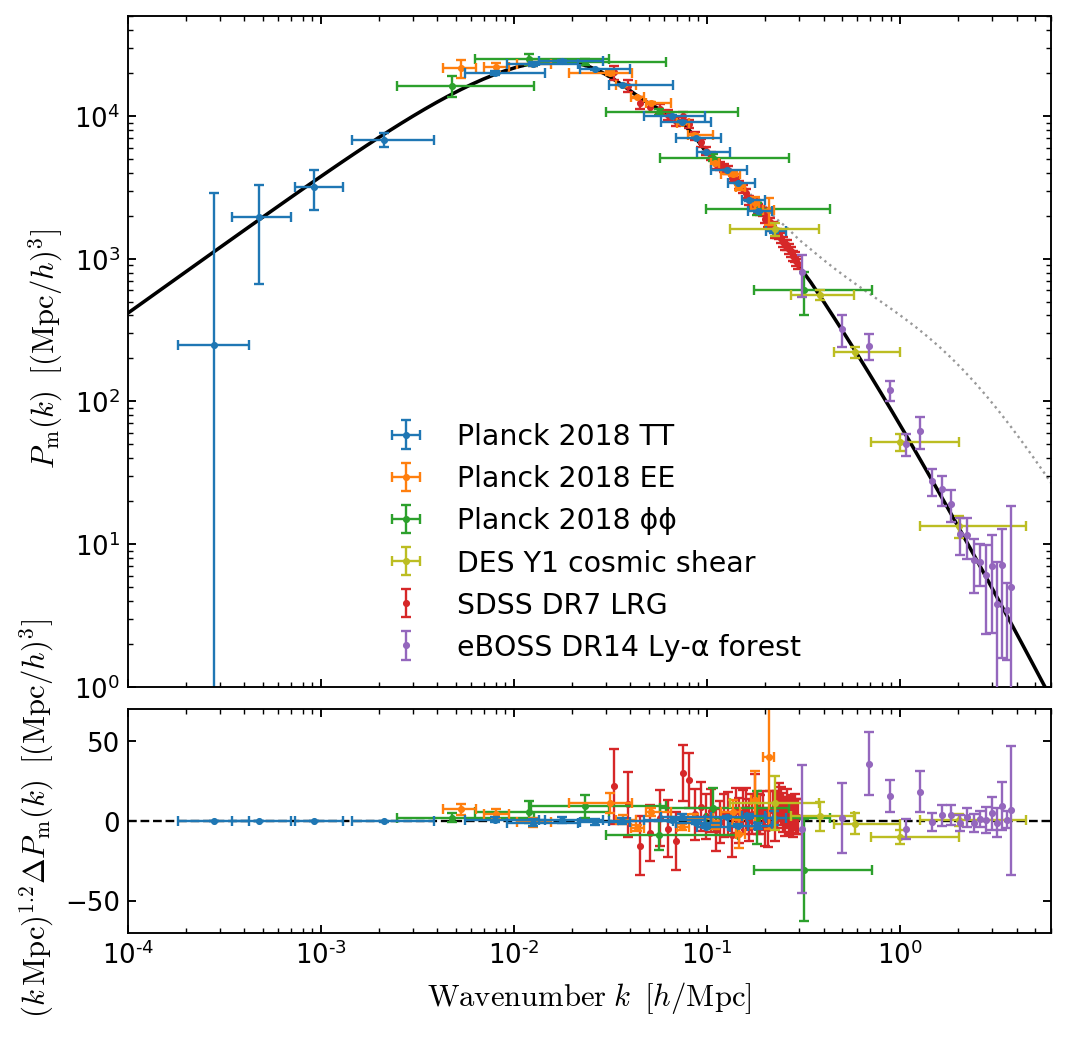

In [47]:
figure(figsize=(7,7),dpi=170)

gs = pyimport("matplotlib.gridspec").GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(hspace=0.05)
ebar_kwargs = Dict(:capsize=>2, :elinewidth=>1, :markeredgewidth=>1, :marker=>".", :ls=>"", :markersize=>4);

# ==========
# Main panel
# ==========

subplot(get(gs,0))


# Fiducial theory model
let k = 10 .^ range(-5,1,length=100)
    plot(k/h, h^3 * PNLkz[k,0],"k:", lw=1, zorder=-10, alpha=0.4)
    plot(k/h, h^3 * Pkz[k,0],"k", zorder=-10)
end



# Planck
let k=k_CMB, ℓ=ℓ_CMB
    make_plot(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, ℓ, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)])..., label="Planck 2018 TT", zorder=-1)
    make_plot(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, ℓ, [fill(5,2); fill(10,5); fill(20,6); 19])...,            label="Planck 2018 EE", zorder=-2)
    make_plot(get_plot_data(d_ϕϕ,        Σ_ϕϕ,        B_ϕϕ,            (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)), Wkℓϕϕ, k, ℓ, [1,1,2,2,2,3,3])...,            label="Planck 2018 ϕϕ", zorder=-3)
    # make_plot(get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])...,            label="Planck TE")
end


# DES
make_plot(σξb ./ ξb_theory, kb_DES, (ξb_data ./ ξb_theory), label="DES Y1 cosmic shear", c="C8")


# Reid et al. 2010
α_reid = 1 ./ Fnuis.(k_reid,x_nuis_reid...) .* (Pkz(k_reid,0)./Pk_halo(k_reid)) * h^3
errorbar(k_reid/h, α_reid .* d_reid_Pk, yerr=(α_reid .* σ_reid_Pk), label="SDSS DR7 LRG", zorder=-5; ebar_kwargs...)


# Lyman-alpha forest
errorbar(k_lyaf/h, Pk_lyaf, yerr = σ_lyaf_Pk, label="eBOSS DR14 Ly-α forest", zorder=4; ebar_kwargs...)



xscale("log")
yscale("log")
legend(loc="lower center")
xlim(1e-4,6)
ylim(1,5e4)
ylabel(raw"$\; P_{\rm m}(k) \;\; [({\rm Mpc}/h)^3]$")
gca().set_xticklabels([])


# ==============
# Residual panel
# ==============

subplot(get(gs,1))

kpow = 1.2

# Planck
let k=k_CMB, ℓ=ℓ_CMB
    make_plot(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, ℓ, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)])..., zorder=-1, residual=true, kpow=kpow)
    make_plot(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, ℓ, [fill(5,2); fill(10,5); fill(20,6); 19])...,            zorder=-2, residual=true, kpow=kpow)
    make_plot(get_plot_data(d_ϕϕ,        Σ_ϕϕ,        B_ϕϕ,            (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)), Wkℓϕϕ, k, ℓ, [1,1,2,2,2,3,3])...,            zorder=-3, residual=true, kpow=kpow)
end

# DES
make_plot(σξb ./ ξb_theory, kb_DES, (ξb_data ./ ξb_theory), label="DES Y1 cosmic shear", c="C8", residual=true, kpow=kpow)


# Reid et al. 2010
α_reid = 1 ./ Fnuis.(k_reid,x_nuis_reid...) .* (Pkz(k_reid,0)./Pk_halo(k_reid)) * h^3
errorbar(k_reid/h, k_reid.^kpow .* (α_reid .* d_reid_Pk .- h^3*Pkz[k_reid,0]), yerr=k_reid.^kpow .* (α_reid .* σ_reid_Pk), label="SDSS DR7 LRG", zorder=-5; ebar_kwargs...)


# Lyman-alpha forest
errorbar(k_lyaf/h, k_lyaf.^kpow .* (Pk_lyaf .- h^3*Pkz[k_lyaf,0]), yerr = k_lyaf.^kpow .* σ_lyaf_Pk, label="eBOSS DR14 Ly-α forest", zorder=4; ebar_kwargs...)


plot([1e-4, 6], [0,0], "k--", lw=1, zorder=-100)
xscale("log")
yscale("linear")

xlim(1e-4,6)
ylim(-70,70)

ylabel(raw"$\; (k \, {\rm Mpc})^{1.2} \Delta P_{\rm m}(k) \;\; [({\rm Mpc}/h)^3] $")
xlabel(raw"${\rm Wavenumber} \; k \;\; [h/{\rm Mpc}]$")


savefig("mpk_compilation.pdf", bbox_inches="tight")
savefig("mpk_compilation.png", bbox_inches="tight")

## $\chi^2$'s

In [48]:
plot_data_to_χ²(dat) = (sum(@. (dat[3] - 1)^2 / (dat[1]^2)), length(dat[1]))

plot_data_to_χ² (generic function with 1 method)

In [49]:
let k=k_CMB, ℓ=ℓ_CMB
    global χ²TT = plot_data_to_χ²(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, k, ℓ, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)]))
    global χ²EE = plot_data_to_χ²(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, k, ℓ, [fill(5,2); fill(10,5); fill(20,6); 19]))
    global χ²ϕϕ = plot_data_to_χ²(get_plot_data(d_ϕϕ,        Σ_ϕϕ,        B_ϕϕ,            (@. Cℓϕϕ * (ℓ*(ℓ+1))^2/(2π)), Wkℓϕϕ, k, ℓ, [1,1,2,2,2,3,3]))
end

(5.012887618420291, 7)

In [50]:
χ²DES = plot_data_to_χ²((σξb ./ ξb_theory, kb_DES, (ξb_data ./ ξb_theory)))

(5.448668255428651, 5)

In [51]:
χ²LRG = (sum(@. (k_reid^kpow * (α_reid * d_reid_Pk - h^3*Pkz[k_reid,0]))^2 / (k_reid^kpow * (α_reid * σ_reid_Pk))^2), length(k_reid))

(16.16570734353689, 45)

In [52]:
χ²Lyα = (sum(@. (k_lyaf^kpow * (Pk_lyaf - h^3*Pkz[k_lyaf,0]))^2 / (k_lyaf.^kpow .* σ_lyaf_Pk)^2), length(k_lyaf))

(9.914315595773768, 19)

In [53]:
@. χ²TT + χ²EE + χ²ϕϕ + χ²DES + χ²LRG + χ²Lyα

(117.29020605313815, 108)

In [54]:
sqrt(2*108)

14.696938456699069